In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px # choropleth maps
from IPython.display import Image
import os
import sys
import json
# plotly maps
# import plotly.figure_factory as ff
# from urllib.request import urlopen

# sys.path.append(os.path.abspath("C:/Users/Alex/Documents/My Data Files/COVID Research/analysis/mention_2_hashtag.py"))

# from analysis.functions.mention_2_hashtag import * 
# from analysis.functions.datamanip import *

# n grams
from sklearn.feature_extraction.text import CountVectorizer

raw = pd.read_csv('flair.joined.tweets.csv')

# changing date to more readable format
raw['created_at'] = pd.to_datetime(raw['created_at'])

# getting seperated date and time columns
raw['date'] = raw['created_at'].dt.date
raw['week'] = raw['created_at'].dt.week
raw['time'] = raw['created_at'].dt.time
raw['hour'] = raw['created_at'].dt.hour

min_wk = raw['week'].min()
max_wk = raw['week'].max()

min_date = raw['date'].min()
max_date = raw['date'].max()

# changing na to None
raw = raw.fillna('None')

raw = raw[raw['sentiment'] != 'None']

raw['is_negative'] = [1 if 'NEGATIVE' in str(sent) else 0 for sent in raw['sentiment']]
raw['is_positive'] = [1 if 'POSITIVE' in str(sent) else 0 for sent in raw['sentiment']]


def convert_fips(unknown_fips_list, fin):
    
    def convert(fipsline):
        name, postal, fips= fipsline.strip().split('\t')

        return {fips: name}

    fips_dict = {f: n 
                for dic in [convert(line)for line in open(fin, 'r')]
                for f, n in dic.items()}

    return [fips_dict[f'{unknown:02d}'] for unknown in unknown_fips_list]

raw = raw[raw['statefips'] != 'None']

raw['state_name'] = convert_fips([int(float(fips)) for fips in raw['statefips']],
                     '../analysis/functions/state.fips.txt')

us_state_abbrev = json.load(open('state_abbreviations.json'))

raw['state_abv'] = [us_state_abbrev[s] for s in raw['state_name']]

raw['fips'] = [f'{int(float(state)):02d}{int(float(county)):03d}' for i, state, county in raw[['statefips', 'countyfips']].itertuples()]
raw['count'] = 1
# raw.head()

all_splits = pd.to_datetime(['2020-03-05', '2020-03-26', '2020-05-01'])
raw['stage'] = ['s:1' if date < all_splits[0] else 's:2' if date < all_splits[1] else 's:3' if date < all_splits[2] else 's:4' for date in raw['date']]

##################
# cdc

keywords = ['social distancing', 'social distance', 'physical distance', '6 feet', 'stay at home', 'school isolation', 'isolation', 'stay home', 'avoid touching', 'mask', 'covering', 'face shield', 'wear a mask', 'surgical mask', 'N95 respirator', 'wearing gloves', 'face shields', 'facial covering', 'skin protection', 'eye protection', 'ppe', 'wash hands', 'hand sanitizer', 'disinfect', 'clean', 'detergent', 'handwashing', 'hand hygiene', 'prevention hygiene', 'sprays', 'concentrates', 'wipes', 'routine cleaning', 'bleach solution', 'test', 'business closure']

topics = []
indexes = {i:0 for i in range(len(raw.index))}

for i, topic in enumerate(keywords):
    topics.append([1 if topic in text else 0 for text in raw['ogtext']])

for i, kw in enumerate(topics):
    for data_ind, value in enumerate(topics[i]):
        indexes[data_ind] += value

raw['in_cdc'] = [indexes[i] if 0 <= indexes[i] <= 1 else 1 for i in indexes]

cdc = raw[raw['in_cdc'] == 1]

cdc_splits = pd.to_datetime(['2020-03-12', '2020-04-20', '2020-05-14'])
cdc['stage'] = ['s:1' if date < cdc_splits[0] else 's:2' if date < cdc_splits[1] else 's:3' if date < cdc_splits[2] else 's:4' for date in cdc['date']]

# print(f'there are a total of {len(cdc.index)} tweets after subsetting for cdc keywords')
# print(raw)
# print(cdc)
print('loaded...')

loaded...


# summary statistics

In [37]:
print(f'min date = {raw["date"].min()}, max date = {raw["date"].max()}')

print(f'in the raw dataset ....')

n, avgNeg, stdNeg = raw.agg({'count':'count', 'is_negative':'mean', 'is_positive':'std'})
per_day = raw.groupby(['date']).agg({'count':'count'}).mean()[0]
std_day = raw.groupby(['date']).agg({'count':'count'}).std()[0]
per_week = raw.groupby(['week']).agg({'count':'count'}).mean()[0]
std_week = raw.groupby(['week']).agg({'count':'count'}).std()[0]
nLocations = len(raw['state_name'].unique())

print(f'n words = {n}, avg neg = {avgNeg}, std neg = {stdNeg}')
print(f'avg tweets per day = {per_day}, std = {std_day}')
print(f'avg tweets per week = {per_week}, std = {std_week}')
print(f'number of unique locations = {nLocations}')


print()
print(f'in the cdc subset ....')

n, avgNeg, stdNeg = cdc.agg({'count':'count', 'is_negative':'mean', 'is_positive':'std'})
per_day = cdc.groupby(['date']).agg({'count':'count'}).mean()[0]
std_day = cdc.groupby(['date']).agg({'count':'count'}).std()[0]
per_week = cdc.groupby(['week']).agg({'count':'count'}).mean()[0]
std_week = cdc.groupby(['week']).agg({'count':'count'}).std()[0]
nLocations = len(cdc['state_name'].unique())

print(f'n words = {n}, avg neg = {avgNeg}, std neg = {stdNeg}')
print(f'avg tweets per day = {per_day}, std = {std_day}')
print(f'avg tweets per week = {per_week}, std = {std_week}')
print(f'number of unique locations = {nLocations}')

min date = 2020-01-22, max date = 2020-06-12
in the raw dataset ....
n words = 344218.0, avg neg = 0.634202743610154, std neg = 0.4816537112602814
avg tweets per day = 2424.0704225352115, std = 1488.957885118977
avg tweets per week = 16391.333333333332, std = 6935.529138669474
number of unique locations = 54

in the cdc subset ....
n words = 53272.0, avg neg = 0.6814273915002252, std neg = 0.46592722253919694
avg tweets per day = 375.15492957746477, std = 294.5514511708853
avg tweets per week = 2536.7619047619046, std = 1529.666136931909
number of unique locations = 54


# thresholds

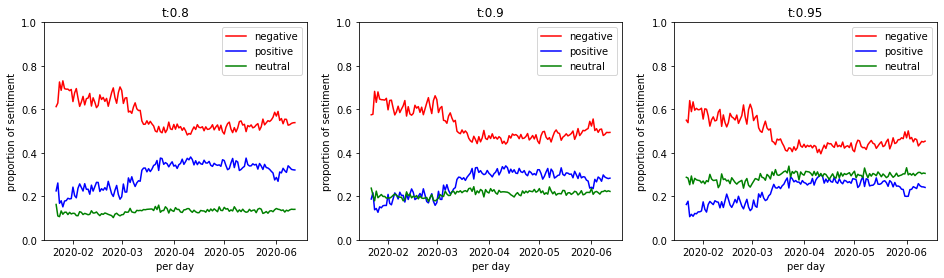

In [2]:
thresholds = [0.8, 0.9, 0.95]
for thresh in thresholds:
    raw[f't:{thresh}'] = [1 if float(conf) > thresh else 0 for conf in raw['sent_confidence']]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4)) #sharey = True

colslist = ['t:0.8', 't:0.9', 't:0.95']

for i, col in enumerate(colslist):

    ndf = raw

    ndf['category'] = ['NEUT' if t == 0 else 'POS' if p == 1 else 'NEG' for i, n, p, t in ndf[['is_negative', 'is_positive', col]].itertuples()]
    ndf['NEUT'] = [1 if cat == 'NEUT' else 0 for cat in ndf['category']]
    ndf['POS'] = [1 if cat == 'POS' else 0 for cat in ndf['category']]
    ndf['NEG'] = [1 if cat == 'NEG' else 0 for cat in ndf['category']]

    ndf = ndf.groupby(['date']).agg({'NEG':'mean', 'POS':'mean', 'NEUT':'mean'}).reset_index()

    ax[i].plot(ndf['date'], ndf.NEG, color= 'r', label='negative')
    ax[i].plot(ndf['date'], ndf.POS, color = 'b', label='positive')
    ax[i].plot(ndf['date'], ndf.NEUT, color = 'g', label='neutral')
    # ax[i].plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
    ax[i].set_ylabel('proportion of sentiment')
    ax[i].set_xlabel('per day')
    ax[i].set_title(f'{col}')
    ax[i].set_ylim(0,1)
    ax[i].legend()
plt.show()


# General stats

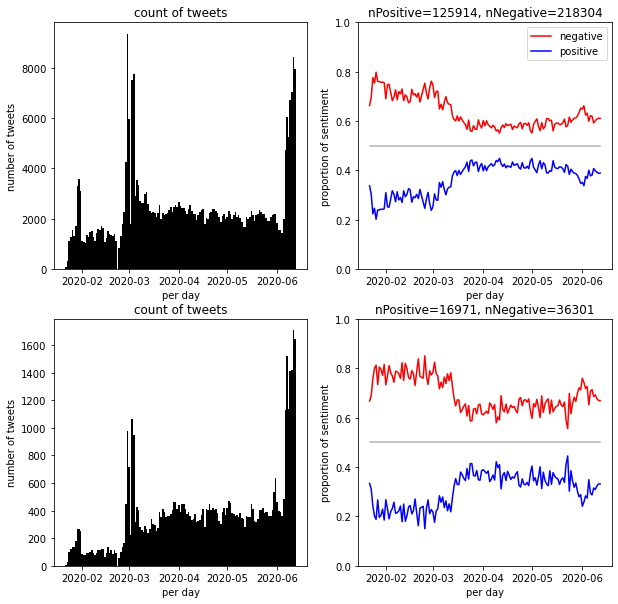

In [24]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4)) #sharey = True
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10)) #sharey = True

ndf = raw.groupby(['date']).agg({'is_negative':'mean', 'count':'count'}).reset_index()
ndf['nnegative'] = ndf['count'] * ndf['is_negative']
ndf['npositive'] = ndf['count'] - ndf['nnegative']
ndf['is_positive'] = 1 - ndf['is_negative']
sum = ndf['count'].sum()
avg_day = ndf['count'].mean()
npos = int(ndf['npositive'].sum())
nneg = int(ndf['nnegative'].sum())

# urban rural split by weeks
df = raw.groupby(['week', 'is_urban']).agg({'is_negative':'mean', 'count':'count', 'is_positive':'mean'}).reset_index()
urban = df[df['is_urban'] == 1]
rural = df[df['is_urban'] == 0]
avg_wk = df['count'].mean()

# ax[0].bar(ndf['date'], ndf.npositive, color= 'black', label='negative')
# ax[0].bar(ndf['date'], ndf.nnegative, bottom = ndf.npositive, color = 'black', label='positive',width=1.0)
ax[0,0].bar(ndf['date'], ndf['count'], color= 'black', label='all tweets', width=1.0)
ax[0,0].set_ylabel('number of tweets')
ax[0,0].set_xlabel('per day')
ax[0,0].set_title(f'count of tweets')

ax[0,1].plot(ndf['date'], ndf.is_negative, color= 'r', label='negative')
ax[0,1].plot(ndf['date'], ndf.is_positive, color = 'b', label='positive')
ax[0,1].plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
ax[0,1].set_ylabel('proportion of sentiment')
ax[0,1].set_xlabel('per day')
ax[0,1].set_title(f'nPositive={npos}, nNegative={nneg}')
ax[0,1].set_ylim(0,1)
ax[0,1].legend()

###########################################################

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4)) #sharey = True

ndf = cdc.groupby(['date']).agg({'is_negative':'mean', 'count':'count'}).reset_index()
ndf['nnegative'] = ndf['count'] * ndf['is_negative']
ndf['npositive'] = ndf['count'] - ndf['nnegative']
ndf['is_positive'] = 1 - ndf['is_negative']
sum = ndf['count'].sum()
avg_day = ndf['count'].mean()
npos = int(ndf['npositive'].sum())
nneg = int(ndf['nnegative'].sum())

# urban rural split by weeks
df = cdc.groupby(['week', 'is_urban']).agg({'is_negative':'mean', 'count':'count', 'is_positive':'mean'}).reset_index()
urban = df[df['is_urban'] == 1]
rural = df[df['is_urban'] == 0]
avg_wk = df['count'].mean()

# ax[0].bar(ndf['date'], ndf.npositive, color= 'black', label='negative')
# ax[0].bar(ndf['date'], ndf.nnegative, bottom = ndf.npositive, color = 'black', label='positive',width=1.0)
ax[1,0].bar(ndf['date'], ndf['count'], color= 'black', label='all tweets', width=1.0)
ax[1,0].set_ylabel('number of tweets')
ax[1,0].set_xlabel('per day')
ax[1,0].set_title(f'count of tweets')
# ax[1,0].set_ylim(0,8000)

ax[1,1].plot(ndf['date'], ndf.is_negative, color= 'r', label='negative')
ax[1,1].plot(ndf['date'], ndf.is_positive, color = 'b', label='positive')
ax[1,1].plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
ax[1,1].set_ylabel('proportion of sentiment')
ax[1,1].set_xlabel('per day')
ax[1,1].set_title(f'nPositive={npos}, nNegative={nneg}')
ax[1,1].set_ylim(0,1)

# fig.suptitle(f'cdc subsetted data: n={sum}, tweets/day={int(avg_day)}, tweets/week={int(avg_wk)}', y=1.03)
plt.show()

# redo general stats

which do i like better?

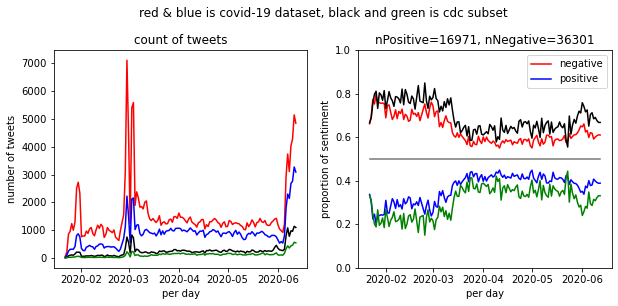

In [42]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4)) #sharey = True
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4)) #sharey = True

ndf = raw.groupby(['date']).agg({'is_negative':'mean', 'count':'count'}).reset_index()
ndf['nnegative'] = ndf['count'] * ndf['is_negative']
ndf['npositive'] = ndf['count'] - ndf['nnegative']
ndf['is_positive'] = 1 - ndf['is_negative']
sum = ndf['count'].sum()
avg_day = ndf['count'].mean()
npos = int(ndf['npositive'].sum())
nneg = int(ndf['nnegative'].sum())

# urban rural split by weeks
df = raw.groupby(['week', 'is_urban']).agg({'is_negative':'mean', 'count':'count', 'is_positive':'mean'}).reset_index()
urban = df[df['is_urban'] == 1]
rural = df[df['is_urban'] == 0]
avg_wk = df['count'].mean()


ax[0].plot(ndf['date'], ndf['nnegative'], label='all tweets', color= 'r')
ax[0].plot(ndf['date'], ndf['npositive'], label='all tweets', color = 'b')
ax[0].set_ylabel('number of tweets')
ax[0].set_xlabel('per day')
ax[0].set_title(f'count of tweets')

ax[1].plot(ndf['date'], ndf.is_negative, color= 'r', label='negative')
ax[1].plot(ndf['date'], ndf.is_positive, color = 'b', label='positive')
ax[1].plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
ax[1].set_ylabel('proportion of sentiment')
ax[1].set_xlabel('per day')
ax[1].set_title(f'nPositive={npos}, nNegative={nneg}')
ax[1].set_ylim(0,1)
ax[1].legend()

ndf = cdc.groupby(['date']).agg({'is_negative':'mean', 'count':'count'}).reset_index()
ndf['nnegative'] = ndf['count'] * ndf['is_negative']
ndf['npositive'] = ndf['count'] - ndf['nnegative']
ndf['is_positive'] = 1 - ndf['is_negative']
sum = ndf['count'].sum()
avg_day = ndf['count'].mean()
npos = int(ndf['npositive'].sum())
nneg = int(ndf['nnegative'].sum())

# urban rural split by weeks
df = cdc.groupby(['week', 'is_urban']).agg({'is_negative':'mean', 'count':'count', 'is_positive':'mean'}).reset_index()
urban = df[df['is_urban'] == 1]
rural = df[df['is_urban'] == 0]
avg_wk = df['count'].mean()

ax[0].plot(ndf['date'], ndf['nnegative'], label='all tweets', color= 'black')
ax[0].plot(ndf['date'], ndf['npositive'], label='all tweets', color = 'g')
ax[0].set_ylabel('number of tweets')
ax[0].set_xlabel('per day')
ax[0].set_title(f'count of tweets')
# ax[1,0].set_ylim(0,8000)

ax[1].plot(ndf['date'], ndf.is_negative, color= 'black', label='negative')
ax[1].plot(ndf['date'], ndf.is_positive, color = 'g', label='positive')
ax[1].plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
ax[1].set_ylabel('proportion of sentiment')
ax[1].set_xlabel('per day')
ax[1].set_title(f'nPositive={npos}, nNegative={nneg}')
ax[1].set_ylim(0,1)

fig.suptitle(f'red & blue is covid-19 dataset, black and green is cdc subset', y=1.03)
plt.show()

stage splitting

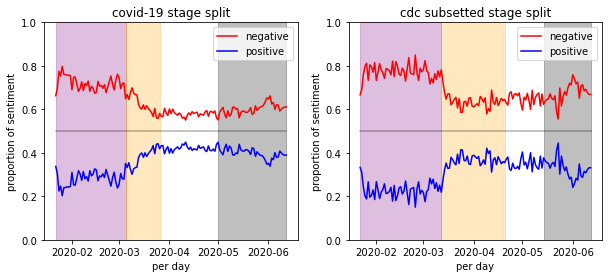

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4)) #sharey = True

ndf = raw.groupby(['date']).agg({'is_negative':'mean', 'count':'count'}).reset_index()
ndf['nnegative'] = ndf['count'] * ndf['is_negative']
ndf['npositive'] = ndf['count'] - ndf['nnegative']
ndf['is_positive'] = 1 - ndf['is_negative']
avg_day = ndf['count'].mean()
npos = int(ndf['npositive'].sum())
nneg = int(ndf['nnegative'].sum())

colors = ['purple', 'orange', 'black']

ax[0].plot(ndf['date'], ndf.is_negative, color= 'r', label='negative')
ax[0].plot(ndf['date'], ndf.is_positive, color = 'b', label='positive')
ax[0].plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
for i, split in enumerate(all_splits):
    if i == 0:
        ax[0].axvspan(min_date, split, 0, 1, alpha=0.25, color=colors[0])
        last = split
    if i != len(all_splits)-1:
        ax[0].axvspan(last, split, 0, 1, alpha=0.25, color=colors[1])
        last = split
    if i == len(all_splits)-1:
        ax[0].axvspan(split, max_date, 0, 1, alpha=0.25, color=colors[2])
ax[0].set_ylabel('proportion of sentiment')
ax[0].set_xlabel('per day')
ax[0].set_title(f'covid-19 stage split')
ax[0].set_ylim(0,1)
ax[0].legend()



ndf = cdc.groupby(['date']).agg({'is_negative':'mean', 'count':'count'}).reset_index()
ndf['nnegative'] = ndf['count'] * ndf['is_negative']
ndf['npositive'] = ndf['count'] - ndf['nnegative']
ndf['is_positive'] = 1 - ndf['is_negative']
avg_day = ndf['count'].mean()
npos = int(ndf['npositive'].sum())
nneg = int(ndf['nnegative'].sum())

colors = ['purple', 'orange', 'black']

ax[1].plot(ndf['date'], ndf.is_negative, color= 'r', label='negative')
ax[1].plot(ndf['date'], ndf.is_positive, color = 'b', label='positive')
ax[1].plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
for i, split in enumerate(cdc_splits):
    if i == 0:
        ax[1].axvspan(min_date, split, 0, 1, alpha=0.25, color=colors[0])
        last = split
    if i != len(cdc_splits)-1:
        ax[1].axvspan(last, split, 0, 1, alpha=0.25, color=colors[1])
        last = split
    if i == len(cdc_splits)-1:
        ax[1].axvspan(split, max_date, 0, 1, alpha=0.25, color=colors[2])
ax[1].set_ylabel('proportion of sentiment')
ax[1].set_xlabel('per day')
ax[1].set_title(f'cdc subsetted stage split')
ax[1].set_ylim(0,1)
ax[1].legend()
plt.show()

# table of stage aresults

In [39]:
print('covid-19 dataset')
table_c19 = raw.groupby(['stage']).agg({'count':'count', 'is_negative':'mean', 'is_positive':'mean'}).reset_index()
table_c19.columns = ['stage', 'n', 'mean Neg', 'mean Pos']

df2 = raw.groupby(['count']).agg({'is_negative':'mean', 'is_positive':'mean'}).reset_index()
df2.columns = ['n', 'mean Neg', 'mean Pos']
df2['n'] = len(raw.index)
print(df2)
print(table_c19)
print()

print('cdc subset')
table_cdc = cdc.groupby(['stage']).agg({'count':'count', 'is_negative':'mean', 'is_positive':'mean'}).reset_index()
table_cdc.columns = ['stage', 'n', 'mean Neg', 'mean Pos']

df2 = cdc.groupby(['count']).agg({'is_negative':'mean', 'is_positive':'mean'}).reset_index()
df2.columns = ['n', 'mean Neg', 'mean Pos']
df2['n'] = len(cdc.index)
print(df2)
print(table_cdc)

covid-19 dataset
        n  mean Neg  mean Pos
0  344218  0.634203  0.365797
  stage       n  mean Neg  mean Pos
0   s:1   89757  0.728901  0.271099
1   s:2   53185  0.627865  0.372135
2   s:3   81871  0.579778  0.420222
3   s:4  119405  0.603157  0.396843

cdc subset
       n  mean Neg  mean Pos
0  53272  0.681427  0.318573
  stage      n  mean Neg  mean Pos
0   s:1  10700  0.772150  0.227850
1   s:2  14142  0.637109  0.362891
2   s:3   9158  0.650033  0.349967
3   s:4  19272  0.678497  0.321503


# topic analysis

In [14]:
social = ['social distancing', 'social distance', 'physical distance', '6 feet', 'stay at home', 'school isolation', 'isolation', 'stay home', 'avoid touching']
gear = ['mask', 'covering', 'face shield', 'wear a mask', 'surgical mask', 'N95 respirator', 'wearing gloves', 'face shields', 'facial covering', 'skin protection', 'eye protection', 'ppe']
clean = ['wash hands', 'hand sanitizer', 'disinfect', 'clean', 'detergent', 'handwashing', 'hand hygiene', 'prevention hygiene', 'sprays', 'concentrates', 'wipes', 'routine cleaning', 'bleach solution']
other = ['test', 'business closure']

categories = [social, gear, clean, other]
cat_names = ['social', 'gear', 'clean', 'other']

for i in range(4):
    raw[cat_names[i]] = 0

for i, text in enumerate(raw.ogtext): # it would be faster to rewrite this to itertuples
    for k, cat in enumerate(categories):
        ncat = 0
        for token in cat:
            if token in str(text):
                ncat += 1
        if ncat > 0:
            raw.loc[i,f'{cat_names[k]}'] = 1

for cat in cat_names: 
    df1 = raw[raw[cat]==1].groupby(['stage']).agg({'count':'count', 'is_negative':'mean', 'is_positive':'std'}).reset_index()
    df1.columns = ['stage', 'n', 'mean Neg', 'std Neg']

    df2 = raw[raw[cat]==1].groupby(['count']).agg({'is_negative':'mean', 'is_positive':'std'}).reset_index()
    df2.columns = ['n', 'mean Neg', 'std Neg']
    df2['n'] = len(raw[raw[cat]==1].index)

    print(f'category: {cat}')
    print(df2)
    print(df1)
    print()

category: social
       n  mean Neg   std Neg
0  19466  0.616771  0.486186
  stage     n  mean Neg   std Neg
0   s:1  1951  0.726294  0.445974
1   s:2  2137  0.628451  0.483332
2   s:3  5549  0.578843  0.493789
3   s:4  9336  0.613753  0.486914

category: gear
       n  mean Neg   std Neg
0  19640  0.635997  0.481162
  stage     n  mean Neg   std Neg
0   s:1  4087  0.731588  0.443187
1   s:2  2193  0.629731  0.482987
2   s:3  3540  0.590395  0.491830
3   s:4  9287  0.612792  0.487138

category: clean
      n  mean Neg   std Neg
0  3061  0.628763  0.483217
  stage    n  mean Neg   std Neg
0   s:1  830  0.714458  0.451945
1   s:2  698  0.590258  0.492139
2   s:3  658  0.589666  0.492269
3   s:4  804  0.605721  0.488999

category: other
       n  mean Neg   std Neg
0  16425  0.635166  0.481399
  stage     n  mean Neg   std Neg
0   s:1  2958  0.727857  0.445139
1   s:2  2288  0.620192  0.485445
2   s:3  2918  0.594928  0.490990
3   s:4  7857  0.619575  0.485522



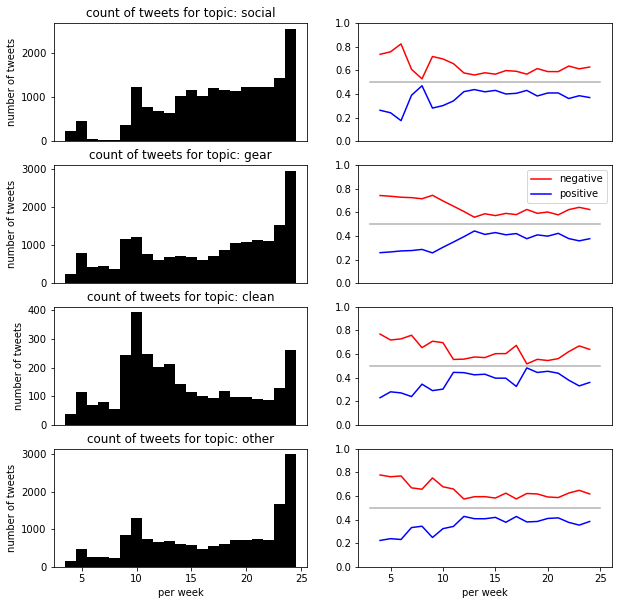

In [27]:
fig, ax = plt.subplots(nrows=len(cat_names), ncols=2, figsize=(10, 10)) #sharey = True
for i, cat in enumerate(cat_names): 
    # fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4)) #sharey = True

    ndf = raw[raw[cat]==1].groupby(['week']).agg({'is_negative':'mean', 'count':'count'}).reset_index()
    ndf['nnegative'] = ndf['count'] * ndf['is_negative']
    ndf['npositive'] = ndf['count'] - ndf['nnegative']
    ndf['is_positive'] = 1 - ndf['is_negative']
    sum = ndf['count'].sum()
    avg_day = ndf['count'].mean()
    npos = int(ndf['npositive'].sum())
    nneg = int(ndf['nnegative'].sum())

    # urban rural split by weeks
    df = raw.groupby(['week', 'is_urban']).agg({'is_negative':'mean', 'count':'count', 'is_positive':'mean'}).reset_index()
    urban = df[df['is_urban'] == 1]
    rural = df[df['is_urban'] == 0]
    avg_wk = df['count'].mean()

    # ax[0].bar(ndf['date'], ndf.npositive, color= 'black', label='negative')
    # ax[0].bar(ndf['date'], ndf.nnegative, bottom = ndf.npositive, color = 'black', label='positive',width=1.0)
    ax[i, 0].bar(ndf['week'], ndf['count'], color= 'black', label='all tweets', width=1.0)
    ax[i, 0].set_ylabel('number of tweets')
    if i == 3:
        ax[i, 0].set_xlabel('per week')
    else:
        ax[i, 0].get_xaxis().set_visible(False)
    ax[i, 0].set_title(f'count of tweets for topic: {cat}')

    ax[i, 1].plot(ndf['week'], ndf.is_negative, color= 'r', label='negative')
    ax[i, 1].plot(ndf['week'], ndf.is_positive, color = 'b', label='positive')
    ax[i, 1].plot((min_wk-1,max_wk+1),(0.5,0.5), color='black', alpha=0.3)
    # ax[1].plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
    # ax[i, 1].set_ylabel('proportion of sentiment')
    if i == 3:
        ax[i, 1].set_xlabel('per week')
    else:
        ax[i, 1].get_xaxis().set_visible(False)
    # ax[i, 1].set_title(f'nPositive={npos}, nNegative={nneg}')
    ax[i, 1].set_ylim(0,1)
    if i == 1:
        ax[i, 1].legend()

# keyword table

In [104]:
for topic in keywords:
    raw['keep'] = [1 if topic in str(text) else 0 for text in raw.ogtext]
    df1 = raw[raw['keep']==1].groupby(['stage']).agg({'count':'count', 'is_negative':'mean', 'is_positive':'std'}).reset_index()
    df1.columns = ['stage', 'n', 'mean Neg', 'std Neg']

    df2 = raw[raw['keep']==1].groupby(['count']).agg({'is_negative':'mean', 'is_positive':'std'}).reset_index()
    df2.columns = ['n', 'mean Neg', 'std Neg']
    df2['n'] = len(raw[raw['keep']==1].index)
    print(f'keyword: {topic}')
    print(df2)
    print(df1)
    print()


keyword: social distancing
       n  mean Neg   std Neg
0  10358  0.612956  0.487097
  stage     n  mean Neg   std Neg
0   s:1    26  0.653846  0.485165
1   s:2  1426  0.581346  0.493511
2   s:3  3459  0.615207  0.486617
3   s:4  5447  0.619607  0.485528

keyword: social distance
     n  mean Neg  std Neg
0  382  0.628272   0.4839
  stage    n  mean Neg   std Neg
0   s:1    3  0.333333  0.577350
1   s:2   35  0.600000  0.497050
2   s:3  123  0.512195  0.501896
3   s:4  221  0.701357  0.458702

keyword: physical distance
    n  mean Neg   std Neg
0  17  0.470588  0.514496
  stage   n  mean Neg   std Neg
0   s:2   1  0.000000       NaN
1   s:3   5  0.400000  0.547723
2   s:4  11  0.545455  0.522233

keyword: 6 feet
   n  mean Neg   std Neg
0  8     0.875  0.353553
  stage  n  mean Neg  std Neg
0   s:2  1      1.00      NaN
1   s:3  3      1.00      0.0
2   s:4  4      0.75      0.5

keyword: stay at home
      n  mean Neg  std Neg
0  3329  0.602283   0.4895
  stage     n  mean Neg   std 

# covid-19 state table

In [135]:
for state, df in raw.groupby(['state_abv']):
    df1 = df.groupby(['stage']).agg({'count':'count', 'is_negative':'mean', 'is_positive':'std'}).reset_index()
    df1.columns = ['stage', 'n', 'mean Neg', 'std Neg']

    df2 = df.groupby(['count']).agg({'is_negative':'mean', 'is_positive':'std'}).reset_index()
    df2.columns = ['n', 'mean Neg', 'std Neg']
    df2['n'] = len(df.index)
    print(f'state: {state}')
    print(df2)
    print(df1)
    print()
    

state: AK
     n  mean Neg   std Neg
0  465  0.660215  0.474146
  stage    n  mean Neg   std Neg
0   s:1  133  0.721805  0.449804
1   s:2   88  0.590909  0.494484
2   s:3  113  0.663717  0.474541
3   s:4  131  0.641221  0.481483

state: AL
      n  mean Neg   std Neg
0  3299  0.623825  0.484498
  stage     n  mean Neg   std Neg
0   s:1   881  0.720772  0.448875
1   s:2   513  0.604288  0.489480
2   s:3   792  0.584596  0.493103
3   s:4  1113  0.584007  0.493114

state: AR
      n  mean Neg   std Neg
0  1864  0.623927  0.484529
  stage    n  mean Neg   std Neg
0   s:1  425  0.734118  0.442323
1   s:2  243  0.609053  0.488970
2   s:3  459  0.549020  0.498134
3   s:4  737  0.611940  0.487639

state: AZ
      n  mean Neg   std Neg
0  8831  0.670479  0.470066
  stage     n  mean Neg   std Neg
0   s:1  2423  0.737103  0.440298
1   s:2  1277  0.670321  0.470281
2   s:3  1902  0.607256  0.488489
3   s:4  3229  0.657789  0.474523

state: CA
       n  mean Neg  std Neg
0  56194  0.635299  0.4813

# cdc subset state table

In [136]:
for state, df in cdc.groupby(['state_abv']):
    df1 = df.groupby(['stage']).agg({'count':'count', 'is_negative':'mean', 'is_positive':'std'}).reset_index()
    df1.columns = ['stage', 'n', 'mean Neg', 'std Neg']

    df2 = df.groupby(['count']).agg({'is_negative':'mean', 'is_positive':'std'}).reset_index()
    df2.columns = ['n', 'mean Neg', 'std Neg']
    df2['n'] = len(df.index)
    print(f'state: {state}')
    print(df2)
    print(df1)
    print()

state: AK
    n  mean Neg   std Neg
0  73  0.630137  0.486108
  stage   n  mean Neg   std Neg
0   s:1  13  0.692308  0.480384
1   s:2  25  0.520000  0.509902
2   s:3  11  0.909091  0.301511
3   s:4  24  0.583333  0.503610

state: AL
     n  mean Neg   std Neg
0  475  0.667368  0.471653
  stage    n  mean Neg   std Neg
0   s:1   81  0.790123  0.409758
1   s:2  141  0.617021  0.487846
2   s:3   91  0.604396  0.491689
3   s:4  162  0.685185  0.465882

state: AR
     n  mean Neg   std Neg
0  272  0.669118  0.471398
  stage    n  mean Neg   std Neg
0   s:1   37  0.756757  0.434959
1   s:2   74  0.594595  0.494322
2   s:3   45  0.711111  0.458368
3   s:4  116  0.672414  0.471369

state: AZ
      n  mean Neg  std Neg
0  1400  0.711429  0.45326
  stage    n  mean Neg   std Neg
0   s:1  244  0.799180  0.401437
1   s:2  301  0.614618  0.487496
2   s:3  246  0.691057  0.463000
3   s:4  609  0.732348  0.443099

state: CA
      n  mean Neg   std Neg
0  8588   0.68619  0.464067
  stage     n  mean N

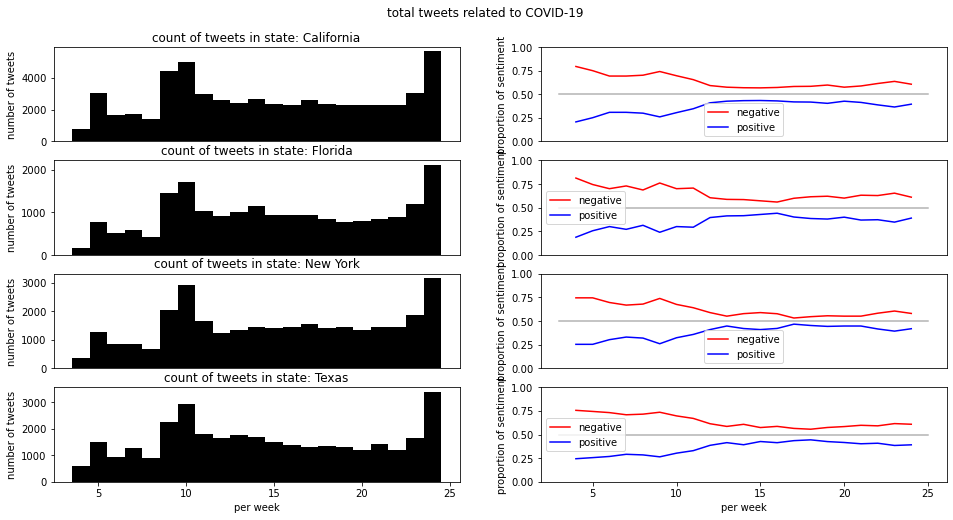

In [14]:
chosen_states = ['California', 'Texas', 'New York', 'Florida']

states = raw[raw['state_name'].isin(chosen_states)]

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(16, 8)) #sharey = True

for i, (state, df) in enumerate(states.groupby('state_name')):

    ndf = df.groupby(['week']).agg({'is_negative':'mean', 'count':'count'}).reset_index()
    ndf['nnegative'] = ndf['count'] * ndf['is_negative']
    ndf['npositive'] = ndf['count'] - ndf['nnegative']
    ndf['is_positive'] = 1 - ndf['is_negative']
    sum = ndf['count'].sum()
    avg_day = ndf['count'].mean()
    npos = int(ndf['npositive'].sum())
    nneg = int(ndf['nnegative'].sum())


    ax[i,0].bar(ndf['week'], ndf['count'], color= 'black', label='all tweets', width=1.0)
    ax[i,0].set_ylabel('number of tweets')
    ax[i,0].set_title(f'count of tweets in state: {state}')
    if i == 3:
        ax[i, 0].set_xlabel('per week')
    else:
        ax[i, 0].get_xaxis().set_visible(False)

    ax[i,1].plot(ndf['week'], ndf.is_negative, color= 'r', label='negative')
    ax[i,1].plot(ndf['week'], ndf.is_positive, color = 'b', label='positive')
    # ax[1].plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
    ax[i,1].plot((min_wk-1,max_wk+1),(0.5,0.5), color='black', alpha=0.3)
    ax[i,1].set_ylabel('proportion of sentiment')
    ax[i,1].set_xlabel('per day')
    # ax[i,1].set_title(f'nPositive={npos}, nNegative={nneg}')
    ax[i,1].set_ylim(0,1)
    ax[i,1].legend()
    if i == 3:
        ax[i, 1].set_xlabel('per week')
    else:
        ax[i, 1].get_xaxis().set_visible(False)

    fig.suptitle(f'total tweets related to COVID-19', y=.95)
plt.show()

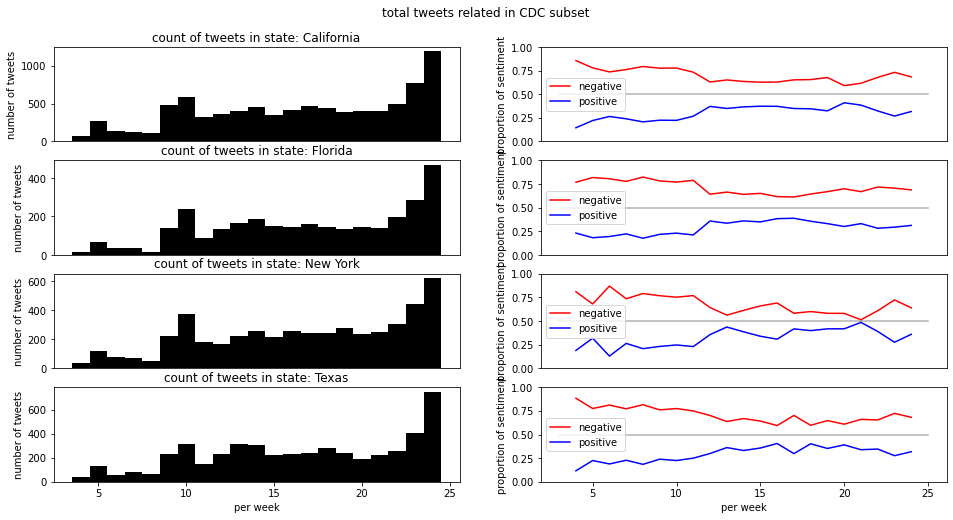

In [15]:
chosen_states = ['California', 'Texas', 'New York', 'Florida']

states = cdc[cdc['state_name'].isin(chosen_states)]

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(16, 8)) #sharey = True

for i, (state, df) in enumerate(states.groupby('state_name')):

    ndf = df.groupby(['week']).agg({'is_negative':'mean', 'count':'count'}).reset_index()
    ndf['nnegative'] = ndf['count'] * ndf['is_negative']
    ndf['npositive'] = ndf['count'] - ndf['nnegative']
    ndf['is_positive'] = 1 - ndf['is_negative']
    sum = ndf['count'].sum()
    avg_day = ndf['count'].mean()
    npos = int(ndf['npositive'].sum())
    nneg = int(ndf['nnegative'].sum())


    ax[i,0].bar(ndf['week'], ndf['count'], color= 'black', label='all tweets', width=1.0)
    ax[i,0].set_ylabel('number of tweets')
    ax[i,0].set_title(f'count of tweets in state: {state}')
    if i == 3:
        ax[i, 0].set_xlabel('per week')
    else:
        ax[i, 0].get_xaxis().set_visible(False)

    ax[i,1].plot(ndf['week'], ndf.is_negative, color= 'r', label='negative')
    ax[i,1].plot(ndf['week'], ndf.is_positive, color = 'b', label='positive')
    # ax[1].plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
    ax[i,1].plot((min_wk-1,max_wk+1),(0.5,0.5), color='black', alpha=0.3)
    ax[i,1].set_ylabel('proportion of sentiment')
    ax[i,1].set_xlabel('per day')
    # ax[i,1].set_title(f'nPositive={npos}, nNegative={nneg}')
    ax[i,1].set_ylim(0,1)
    ax[i,1].legend()
    if i == 3:
        ax[i, 1].set_xlabel('per week')
    else:
        ax[i, 1].get_xaxis().set_visible(False)

    fig.suptitle(f'total tweets related in CDC subset', y=.95)
plt.show()